In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Quiz 2 - Get Hyp'

<ul>
<li> Use this as a starting point for your work, but answer the questions on Moodle. 
<li> Publish this to your GitHub and submit the link in the question on Moodle. 
</ul>

## Potentially Useful Information

#### Data Dictionary
<ul>
<li>credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
<li>purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
<li>int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
<li>installment: The monthly installments owed by the borrower if the loan is funded.
<li>log.annual.inc: The natural log of the self-reported annual income of the borrower.
<li>dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
<li>fico: The FICO credit score of the borrower.
<li>days.with.cr.line: The number of days the borrower has had a credit line.
<li>revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
<li>revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
<li>inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
<li>not.fully.paid: 1 if the borrower failed to repay their loan, 0 if they have not failed
</ul>

#### FICO Score Groups

![FICO](fico_range.png "FICO Ranges")

#### Note on ANOVA - Might be Useful, Might Not

> @JeremyMiles is right. First, there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power. Since you have a significant effect anyway, there is less reason to be concerned here. 
- https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance

In [3]:
# Please don't alter this part. 
df = pd.read_csv("loan_data.csv")
df.drop(columns={"delinq.2yrs", "pub.rec"}, inplace=True)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0


In [4]:
# Look at sample data
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,1.000000


### Visualize/Explore Data - If You Want, You Do You

<AxesSubplot:xlabel='fico', ylabel='Density'>

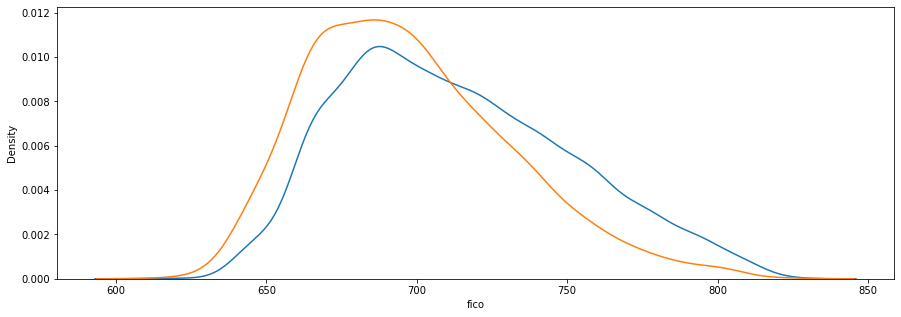

In [18]:
dfPay = df[df["not.fully.paid"] == 0]
dfFailPay = df[df["not.fully.paid"] == 1]
dPay = dfPay.fico
dFail = dfFailPay.fico
sns.kdeplot(dPay)
sns.kdeplot(dFail)


## Solutions

In [14]:
# test 
stat, pval = ss.ttest_ind(dPay, dFail, alternative="greater")
pval
# Check for signifigance
cutoff = .05
if pval < cutoff:
    print("Reject null hypothesis - Effect appears significant")
else:
    print("Accept null hypothesis - Effect may be due to random chance")


Reject null hypothesis - Effect appears significant


In [16]:
dfW = df[df["credit.policy"] == 0]
dfNW = df[df["credit.policy"] == 1]
dW = dfW.fico
dNW = dfNW.fico


In [17]:
# test
stat, pval = ss.ttest_ind(dW, dNW, alternative="greater")
pval
# Check for signifigance
cutoff = .05
if pval < cutoff:
    print("Reject null hypothesis - Effect appears significant")
else:
    print("Accept null hypothesis - Effect may be due to random chance")


Accept null hypothesis - Effect may be due to random chance


In [19]:
dfW = df[df["credit.policy"] == 0]
dfNW = df[df["credit.policy"] == 1]
dW1 = dfW['log.annual.inc']
dNW1 = dfNW['log.annual.inc']
# test
stat, pval = ss.ttest_ind(dW1, dNW1, alternative="greater")
pval
# Check for signifigance
cutoff = .05
if pval < cutoff:
    print("Reject null hypothesis - Effect appears significant")
else:
    print("Accept null hypothesis - Effect may be due to random chance")


Accept null hypothesis - Effect may be due to random chance


In [20]:
# power.
from statsmodels.stats.power import TTestPower
powerTest = TTestPower()
ces = thinkstats2.CohenEffectSize(dW1, dNW1)
alpha = .05
nobs = dW1.count() + dNW1.count()

pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces


(1.0, -0.08813984185782714)

In [21]:
# Calculate n
n = powerTest.solve_power(ces, power=.8, nobs=None, alpha=alpha)
n


1012.2496979701302

In [22]:
# Transformation
incM = np.mean(np.exp(df["log.annual.inc"]))
incM


68402.03071015503

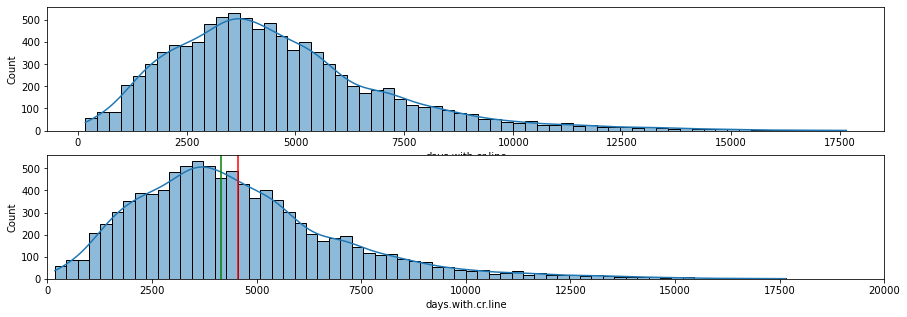

In [25]:
# Graph distribution 
thinkplot.PrePlot(2, 2, 1)
sns.histplot(df["days.with.cr.line"], kde=True)
thinkplot.SubPlot(2)
sns.histplot(df["days.with.cr.line"], kde=True).set(xlim=(0, 20000))
plt.axvline(np.mean(df["days.with.cr.line"]), color="red")
plt.axvline(np.median(df["days.with.cr.line"]), color="green")
plt.ticklabel_format(style='plain', axis='x')
thinkplot.Config()


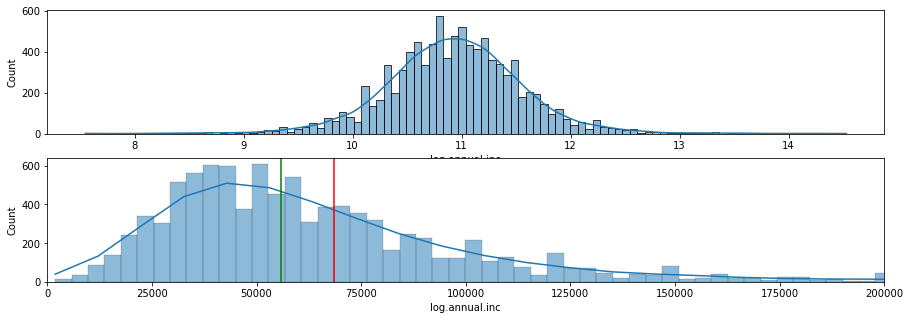

In [26]:
#Graph distribution of log income
thinkplot.PrePlot(2, 2, 1)
sns.histplot(df["log.annual.inc"], kde=True)
thinkplot.SubPlot(2)
sns.histplot(np.exp(df["log.annual.inc"]), kde=True).set(xlim=(0,200000))
plt.axvline(np.mean(np.exp(df["log.annual.inc"])), color="red")
plt.axvline(np.median(np.exp(df["log.annual.inc"])), color="green")
plt.ticklabel_format(style='plain', axis='x')
thinkplot.Config()